# Food Vision Big!!!

In [15]:
!pip install tensorflow==2.11
import tensorflow as tf
print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.11.0


In [16]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1a4f444b-b5e7-7e9c-0e5d-ea078f85ef02)


In [17]:
# !pip install tensorflow_datasets

In [18]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-01 17:04:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-01 17:04:10 (105 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [19]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, make_confusion_matrix

In [20]:
tfds_datasets = tfds.list_builders()
print('food101' in tfds_datasets)

True


In [21]:
(train_data, test_data), ds_info = tfds.load(name='food101', 
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,                # tuple (data, label)
                                             with_info=True)

In [22]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

* class_names
* shape
* one hot encode or label encoded
* data type
* labels match with class_names

In [23]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [24]:
train_sample = train_data.take(1)
train_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [25]:
for image, label in train_sample:
  print(f"""
    Image shape: {image.shape}
    Image data type: {image.dtype}
    Target class from food101 (tensor form): {label}
    Class name (str): {class_names[label.numpy()]}
  """)


    Image shape: (512, 512, 3)
    Image data type: <dtype: 'uint8'>
    Target class from food101 (tensor form): 30
    Class name (str): deviled_eggs
  


In [26]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 28,  31,  50],
        [ 27,  30,  49],
        [ 21,  23,  44],
        ...,
        [ 17,  28,  60],
        [ 20,  30,  65],
        [ 28,  38,  73]],

       [[ 11,  14,  33],
        [ 23,  26,  45],
        [ 24,  26,  47],
        ...,
        [ 39,  50,  82],
        [ 33,  44,  76],
        [ 19,  30,  62]],

       [[ 16,  17,  37],
        [ 23,  24,  44],
        [ 19,  20,  40],
        ...,
        [ 45,  56,  86],
        [ 39,  50,  80],
        [ 36,  47,  77]],

       ...,

       [[148,  94, 117],
        [153,  99, 122],
        [153, 102, 121],
        ...,
        [ 94, 128, 166],
        [ 96, 130, 168],
        [ 96, 131, 169]],

       [[143,  89, 112],
        [151,  97, 120],
        [153, 102, 121],
        ...,
        [102, 134, 173],
        [103, 135, 174],
        [101, 135, 173]],

       [[145,  91, 114],
        [154, 100, 123],
        [158, 107, 126],
        ...,
        [105, 137, 17

In [27]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

# plot an image

In [28]:
def show_image(image, label, figsize=(10, 7)):
  plt.figure(figsize=figsize)
  plt.imshow(image)
  plt.title(f'Sample image from Food101 dataset, {class_names[label.numpy()]}')
  plt.axis(False)

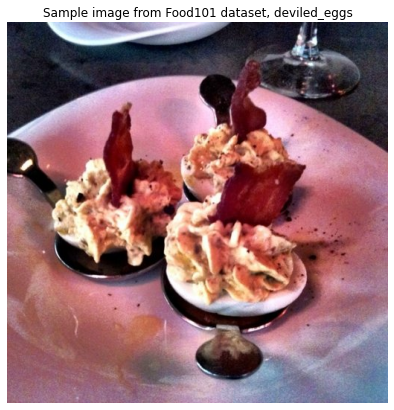

In [29]:
show_image(image, label)

# create preprocessing functions for the data
* batched, normalized, ...
* our data: uint, not scaled (0, 255), different image size

In [30]:
def preprocess_image(image, label, img_shape=224, scale=False):
  """
  convert type from uint8 to float32
  reshape to [img_shape, img_shape, color_channels]
  """
  # resize
  image = tf.image.resize(image, size=[img_shape, img_shape])
  
  # scale
  image = image/255. if scale else image
  
  # convert and return
  return tf.cast(image, tf.float32), label

In [31]:
preprocessed_img = preprocess_image(image, label, scale=False)[0]
print(f'Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, DataType: {image.dtype}')
print(f'Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, DataType: {preprocessed_img.dtype}')

Image before preprocessing:
 [[[28 31 50]
  [27 30 49]
  [21 23 44]
  ...
  [17 28 60]
  [20 30 65]
  [28 38 73]]

 [[11 14 33]
  [23 26 45]
  [24 26 47]
  ...
  [39 50 82]
  [33 44 76]
  [19 30 62]]]..., 
Shape: (512, 512, 3), DataType: <dtype: 'uint8'>
Image after preprocessing:
 [[[21.801022 24.801022 43.80102 ]
  [17.7551   19.7551   40.755104]
  [16.16837  18.16837  41.16837 ]
  ...
  [37.61732  46.831585 75.964294]
  [30.214298 41.2143   72.02044 ]
  [26.163052 36.80591  69.877335]]

 [[22.091837 23.091837 43.09184 ]
  [10.974489 11.974489 31.97449 ]
  [16.112244 17.112244 38.112244]
  ...
  [45.48988  57.48988  81.20421 ]
  [42.413116 54.34169  80.49475 ]
  [33.551304 45.479874 71.76559 ]]]..., 
Shape: (224, 224, 3), DataType: <dtype: 'float32'>


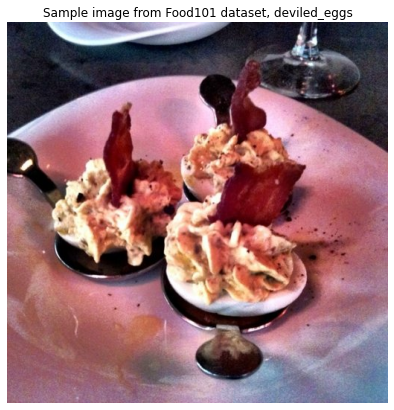

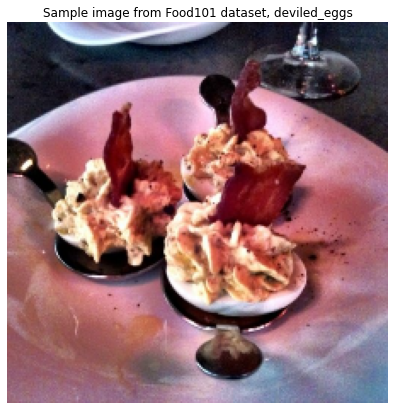

In [32]:
show_image(image, label)
show_image(preprocessed_img/255., label)

In [33]:
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [34]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# create callbacks

In [35]:
tensorboard_callback = create_tensorboard_callback(dir_name='food_vision',
                                                   experiment_name='food_vision_feature_extraction')

checkpoint_path = 'food_vision_model_checkpoints/checkpoint.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                      monitor='val_accuracy',
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      verbose=0)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=.2,
                                                  patience=2,
                                                  verbose=0)

Saving TensorBoard log files to: food_vision/food_vision_feature_extraction/20230301-170445


In [36]:
mixed_precision.set_global_policy('mixed_float16')
mixed_precision.global_policy()

<Policy "mixed_float16">

In [37]:
data_augmentation = tf.keras.models.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(.2),
    layers.RandomZoom(.2),
    layers.RandomHeight(.2),
    layers.RandomWidth(.2),
    # layers.Rescaling(1./255)
], name="data_augmentation")

In [38]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

input_shape = (224, 224, 3)
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_2d')(x)
x = layers.Dense(len(train_data), name='dense')(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_layer')(x)
efficientnetb0_model = tf.keras.Model(inputs, outputs)

efficientnetb0_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                             optimizer=tf.keras.optimizers.Adam(),
                             metrics=['accuracy'])

16705208/16705208 [==============================] - 1s 0us/step


In [39]:
efficientnetb0_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2368)              3033408   
                                                                 
 softmax_layer (Activation)  (None, 2368)              0     

In [40]:
for layer in efficientnetb0_model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
data_augmentation True float32 <Policy "mixed_float16">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling_2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_layer True float32 <Policy "float32">


In [41]:
for layer in base_model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [42]:
initial_epochs = 3
history_efficientnetb0_feat = efficientnetb0_model.fit(train_data,
                                                       epochs=initial_epochs,
                                                       steps_per_epoch=len(train_data),
                                                       validation_data=test_data,
                                                       validation_steps=(.15 * len(test_data)),
                                                       callbacks=[tensorboard_callback, 
                                                                  model_checkpoint])

Epoch 1/3


2368/2368 [==============================] - 586s 239ms/step - loss: 2.1112 - accuracy: 0.5005 - val_loss: 1.2862 - val_accuracy: 0.6518
Epoch 2/3
2368/2368 [==============================] - 549s 231ms/step - loss: 1.5908 - accuracy: 0.5957 - val_loss: 1.1843 - val_accuracy: 0.6815
Epoch 3/3
2368/2368 [==============================] - 535s 225ms/step - loss: 1.4674 - accuracy: 0.6217 - val_loss: 1.1480 - val_accuracy: 0.6917


In [43]:
results_efficientnetb0_feat = efficientnetb0_model.evaluate(test_data)
results_efficientnetb0_feat

790/790 [==============================] - 51s 65ms/step - loss: 1.1577 - accuracy: 0.6866


[1.1577446460723877, 0.6865742802619934]

# save the model

In [44]:
# efficientnetb0_model.save('models/efficientnetb0_model_feat.h5')

In [45]:
from google.colab import files
# files.download('model_efficientnetb0_feat.h5')

In [46]:
from google.colab import drive
drive.mount('/content/drive')
# efficientnetb0_model.save('content/drive/MyDrive/food_vision/models/efficientnetb0_model_feat.h5')

Mounted at /content/drive


In [47]:
# loaded_model = tf.keras.models.load_model('models/efficientnetb0_feat.h5')

In [48]:
# np.isclose(results_efficientnetb0_feat, results_loaded_efficientnetb0)

In [49]:
# loaded_model = tf.keras.models.load_model('content/drive/MyDrive/food_vision/models/efficientnetb0_model_feat')

In [50]:
# np.isclose(results_efficientnetb0_feat, results_loaded_efficientnetb0)

## load the pretrained model and evaluate it

In [51]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
!mkdir models
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d models
loaded_model = tf.keras.models.load_model('models/07_efficientnetb0_feature_extract_model_mixed_precision')

--2023-03-01 17:34:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.251.31.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip.1’

07_efficientnetb0_f 100%[===================>]  16.19M  11.6MB/s    in 1.4s    

2023-03-01 17:34:59 (11.6 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip.1’ saved [16976857/16976857]

mkdir: cannot create directory ‘models’: File exists
Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
replace models/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 

In [52]:
results_loaded_efficientnetb0 = loaded_model.evaluate(test_data)
results_loaded_efficientnetb0

790/790 [==============================] - 56s 68ms/step - loss: 1.0881 - accuracy: 0.7066


[1.0881001949310303, 0.7066138386726379]

In [53]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

# fine tune and beat the DeepFood paper 77.4% top-1 accuracy

In [54]:
loaded_model.trainable = True

for layer in loaded_model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [55]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  mode='min',
                                                  verbose=1)

checkpoint_path = 'models/checkpoint_fine_tuning.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_loss',
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      verbose=1)

tensorboard_callback = create_tensorboard_callback(dir_name='food_vision',
                                                  experiment_name='food_vision_big_fine')

Saving TensorBoard log files to: food_vision/food_vision_big_fine/20230301-173627


In [56]:
loaded_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(0.0001),
                     metrics=['accuracy'])

In [57]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [58]:
fine_tune_epochs = initial_epochs + 100
history_mixed_pre_fine = loaded_model.fit(train_data,
                                          epochs=fine_tune_epochs,
                                          steps_per_epoch=len(train_data),
                                          validation_data=test_data,
                                          validation_steps=(.15 * len(test_data)),
                                          initial_epoch=history_efficientnetb0_feat.epoch[-1],
                                          callbacks=[tensorboard_callback,
                                                     model_checkpoint,
                                                     early_stopping_callback])

Epoch 3/103
2368/2368 [==============================] - 437s 163ms/step - loss: 0.9219 - accuracy: 0.7526 - val_loss: 0.8178 - val_accuracy: 0.7728
Epoch 4/103
2368/2368 [==============================] - 379s 159ms/step - loss: 0.5783 - accuracy: 0.8395 - val_loss: 0.7838 - val_accuracy: 0.7891
Epoch 5/103
2368/2368 [==============================] - 379s 159ms/step - loss: 0.3285 - accuracy: 0.9058 - val_loss: 0.8350 - val_accuracy: 0.7807
Epoch 6/103
2368/2368 [==============================] - 390s 164ms/step - loss: 0.1739 - accuracy: 0.9486 - val_loss: 0.9799 - val_accuracy: 0.7752
Epoch 7/103
2368/2368 [==============================] - 386s 162ms/step - loss: 0.1076 - accuracy: 0.9668 - val_loss: 1.0618 - val_accuracy: 0.7870
Epoch 7: early stopping


In [59]:
results_efficientnetb0_fine_10 = loaded_model.evaluate(test_data)
results_efficientnetb0_fine_10

790/790 [==============================] - 57s 72ms/step - loss: 1.0836 - accuracy: 0.7784


[1.0835527181625366, 0.778415858745575]

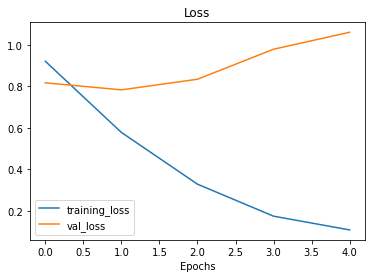

In [60]:
plot_loss_curves(history_mixed_pre_fine)

In [61]:
# loaded_model.save('models/food_vision_big_efficientnetb0_model_mixed_pre_fine.h5')
# loaded_model.save('content/drive/MyDrive/food_vision/models/food_vision_big_efficientnetb0_model_mixed_pre_fine.h5')

In [62]:
# loaded_model.save_weights('models/food_vision_big_efficientnetb0_model_mixed_pre_fine_weights.h5')

In [63]:
from google.colab import files
# files.download('models/food_vision_big_efficientnetb0_model_mixed_pre_fine_weights.h5')

In [64]:
# loaded_model = loaded_model.load_weights('models/food_vision_big_efficientnetb0_model_mixed_pre_fine_weights.h5')

# upload and view on tensorboard dev

In [ ]:
!tensorboard dev upload --logdir ./food_vision \
  --name "food_vision_big_mixedpre_fine_efficientnetb0" \
  --description "food vision big!!! app with EfficientNetB0 model fine tuned using mixed_precision and pipeline" \
  --one_shot

* Done. View your TensorBoard at https://tensorboard.dev/experiment/GFbokWgORGmIrYTmCZ6Z1Q/

In [66]:
!tensorboard dev list

2023-03-01 18:13:15.313531: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-01 18:13:15.313728: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-01 18:13:15.313759: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
https://tensorboard.dev/experiment/GFbokWgORGmIrYTmCZ6Z1Q/
	Name                 food_vision_big_mixedpre_fine_efficientnetb0
	Description          food vision big!!! 

In [67]:
# !tensorboard dev delete --experiment_id 

# Evaluate

In [68]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
!unzip "07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip"

--2023-03-01 18:13:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.127.128, 142.251.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46790356 (45M) [application/zip]
Saving to: ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip.1’

07_efficientnetb0_f 100%[===================>]  44.62M  21.6MB/s    in 2.1s    

2023-03-01 18:13:20 (21.6 MB/s) - ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip.1’ saved [46790356/46790356]

Archive:  07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
replace 07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 07_efficientnetb0_fine_tuned_101_classes_mi

In [69]:
# doesnt have metadata so we must use hub.KerasLayer
# loaded_model = tf.saved_model.load("07_efficientnetb0_fine_tuned_101_classes_mixed_precision/")

In [70]:
# doesn't have metadata
# tf.keras.models.save_model(loaded_model, 'models/loaded_model_fine.h5')

In [71]:
import tensorflow_hub as hub
loaded_model = tf.keras.Sequential([
    hub.KerasLayer('/content/07_efficientnetb0_fine_tuned_101_classes_mixed_precision', trainable=True)
    ])

loaded_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(.0001),
                     metrics=['accuracy'])

In [72]:
pred_probs = efficientnetb0_model.predict(test_data)
y_preds = tf.argmax(pred_probs, axis=1)
y_labels = []
for image, label in test_data.unbatch():
  y_labels.append(label)

true_classes = [class_names[i] for i in y_labels]
pred_classes = [class_names[i] for i in y_preds]

pred_probs[:2], y_preds[:2], y_labels[:2], true_classes[:2], pred_classes[:2], 

790/790 [==============================] - 58s 70ms/step


(array([[2.1472928e-04, 9.0581144e-04, 1.4213544e-04, ..., 7.3766881e-09,
         8.1652498e-09, 5.7449698e-09],
        [2.2538856e-05, 5.4059828e-06, 6.1989158e-05, ..., 2.0754468e-08,
         1.3933891e-08, 9.6517248e-09]], dtype=float32),
 <tf.Tensor: shape=(2,), dtype=int64, numpy=array([44, 60])>,
 [<tf.Tensor: shape=(), dtype=int64, numpy=83>,
  <tf.Tensor: shape=(), dtype=int64, numpy=57>],
 ['red_velvet_cake', 'hummus'],
 ['fried_rice', 'lobster_bisque'])

In [73]:
classification_report_dict = classification_report(y_labels, y_preds, output_dict=True)
classification_report_dict

{'0': {'precision': 0.014423076923076924,
  'recall': 0.012,
  'f1-score': 0.013100436681222708,
  'support': 250},
 '1': {'precision': 0.013468013468013467,
  'recall': 0.016,
  'f1-score': 0.014625228519195612,
  'support': 250},
 '2': {'precision': 0.011363636363636364,
  'recall': 0.012,
  'f1-score': 0.011673151750972763,
  'support': 250},
 '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 250},
 '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 250},
 '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 250},
 '6': {'precision': 0.011363636363636364,
  'recall': 0.012,
  'f1-score': 0.011673151750972763,
  'support': 250},
 '7': {'precision': 0.014285714285714285,
  'recall': 0.016,
  'f1-score': 0.01509433962264151,
  'support': 250},
 '8': {'precision': 0.0049382716049382715,
  'recall': 0.008,
  'f1-score': 0.006106870229007634,
  'support': 250},
 '9': {'precision': 0.01090909090909091,
  'recall': 0.012,
  'f1-score': 0.011428

In [74]:
class_f1_score, class_recall, class_precision = {}, {}, {}
for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break
  class_f1_score[class_names[int(k)]] = v['f1-score']
  class_recall[class_names[int(k)]] = v['recall']
  class_precision[class_names[int(k)]] = v['precision']

In [75]:
f1_score_df = pd.DataFrame({
    'class_name':list(class_f1_score.keys()),
    'f1_score':list(class_f1_score.values())
}).sort_values('f1_score', ascending=False)
f1_score_df.head()

class_name  f1_score
98          tiramisu  0.026101
25     club_sandwich  0.024793
28     croque_madame  0.023952
89  shrimp_and_grits  0.020915
72          pancakes  0.019960

In [76]:
def plot_f1_score(f1_score_df):
  fig, ax = plt.subplots(figsize=(12, 25))
  scores = ax.barh(range(len(f1_score_df)), f1_score_df['f1_score'].values)
  ax.set_yticks(range(len(f1_score_df)))
  ax.set_yticklabels(f1_score_df['class_name'])
  ax.set_xlabel('f1_score')
  ax.set_title('F1_score for 101 classes')
  ax.invert_yaxis()
  autolabel(scores, axis=ax)

def autolabel(rects, axis):
  for rect in rects:
    axis.text(1.03 * rect.get_width(), rect.get_y() + rect.get_height() / 1.5,
              f"{rect.get_width():.2f}",
              ha='center', va='bottom')

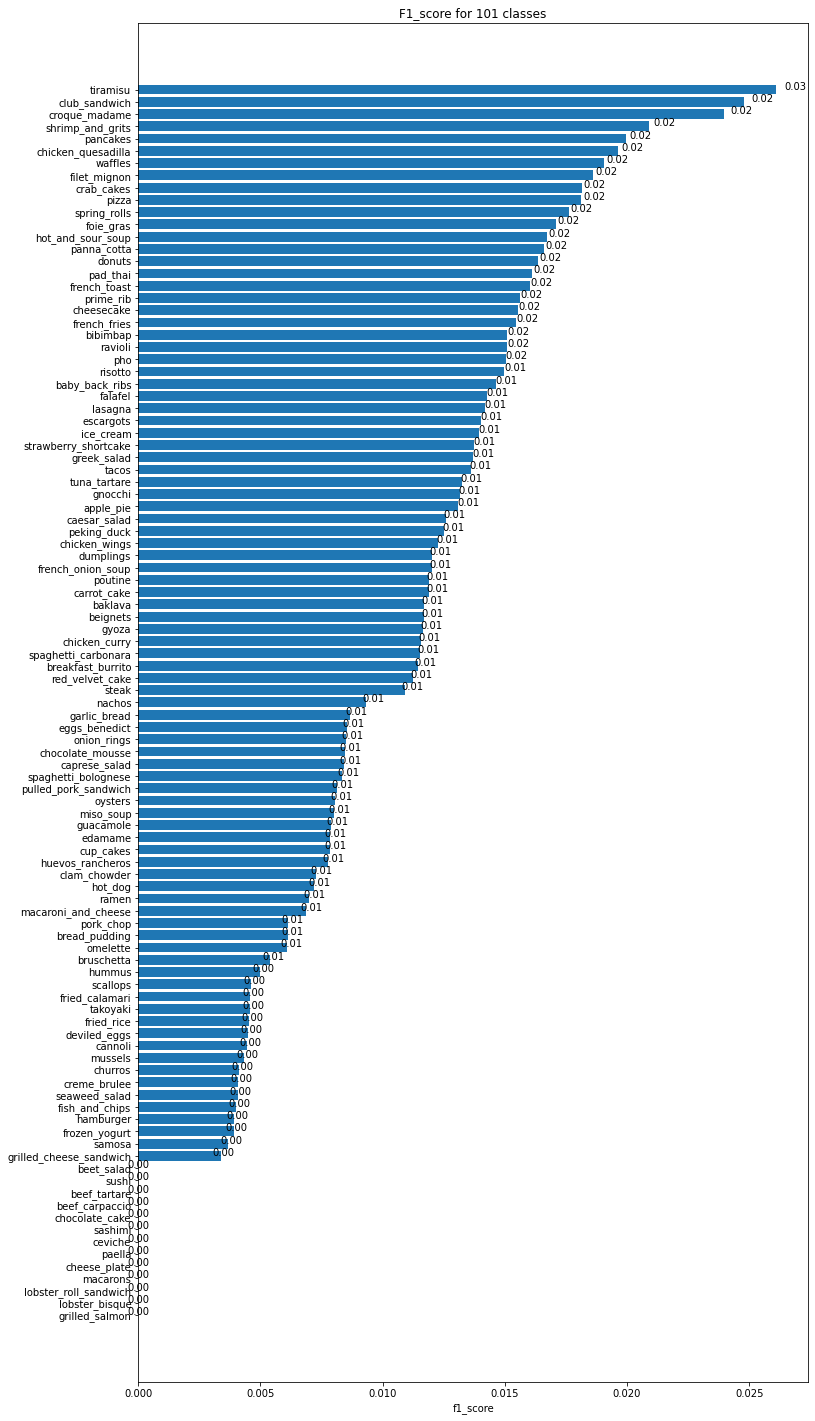

In [77]:
plot_f1_score(f1_score_df)

## confusion matrix

In [78]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # x labels rotation
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

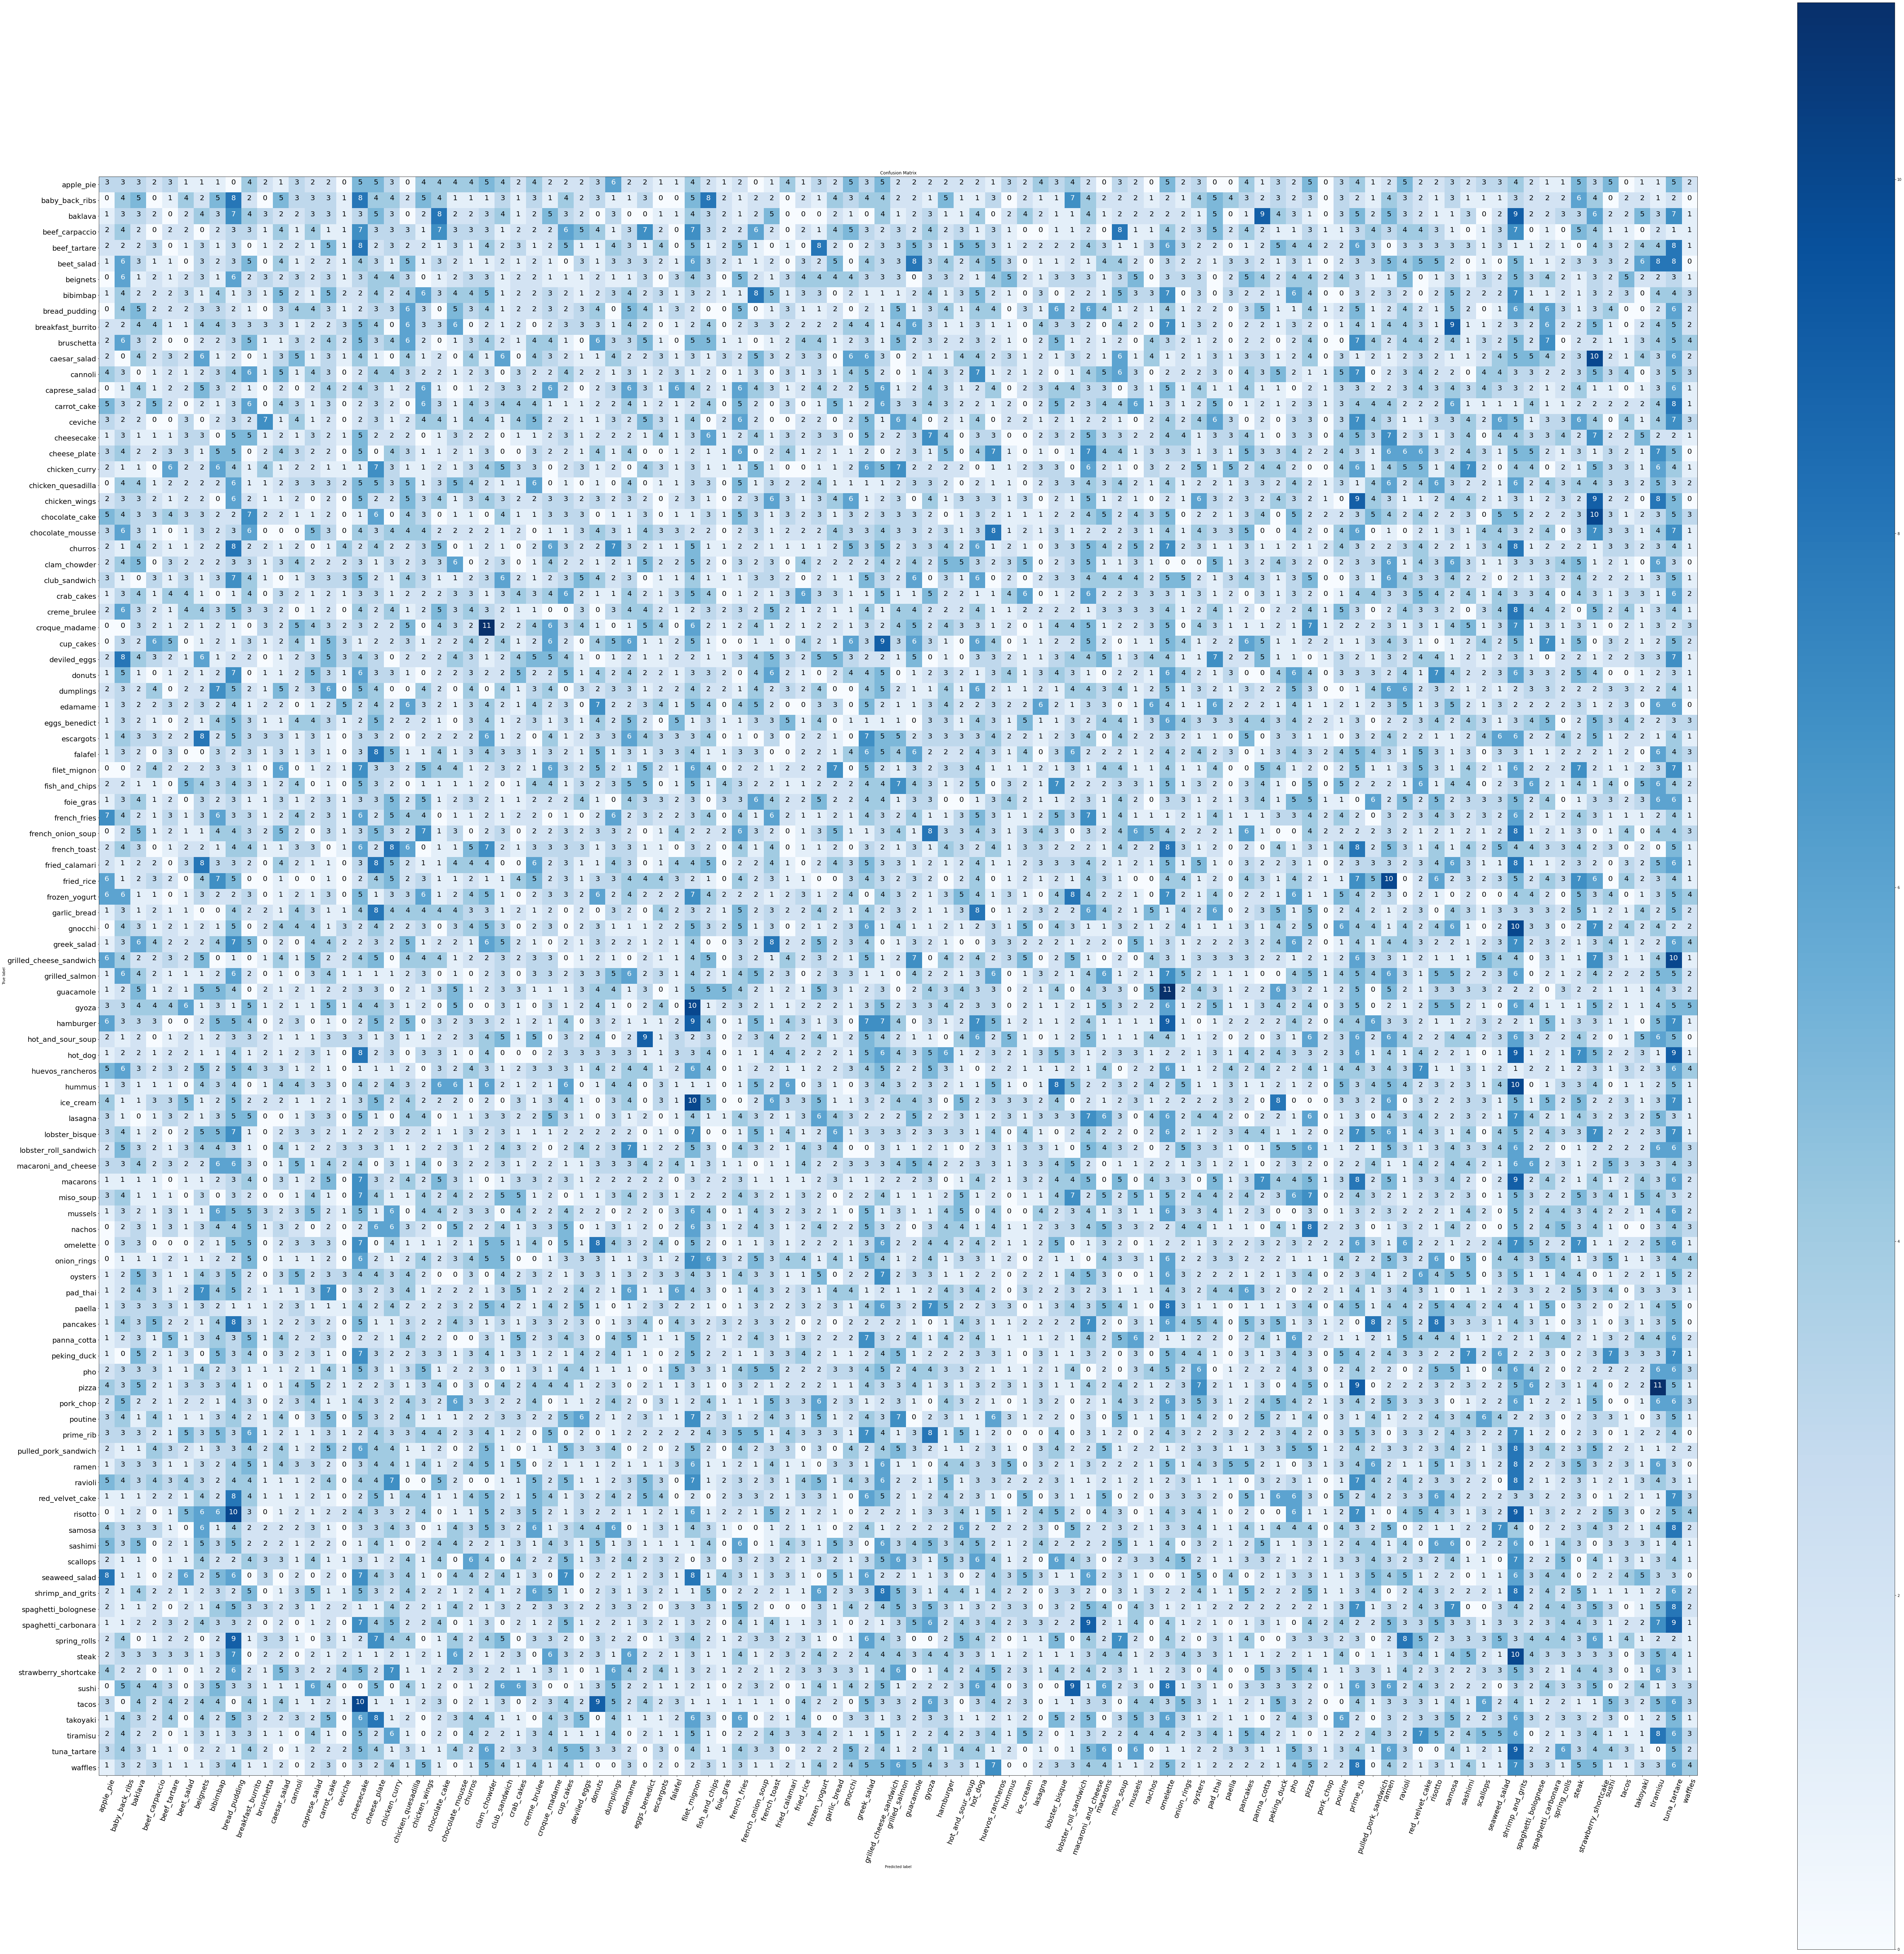

In [79]:
make_confusion_matrix(y_labels, y_preds, classes=class_names, figsize=(100, 100), text_size=20)

In [80]:
for i, (image, label) in enumerate(test_data.unbatch().take(9)):
  print(i, image.shape, label.shape, tf.expand_dims(image, axis=0).shape)

0 (224, 224, 3) () (1, 224, 224, 3)
1 (224, 224, 3) () (1, 224, 224, 3)
2 (224, 224, 3) () (1, 224, 224, 3)
3 (224, 224, 3) () (1, 224, 224, 3)
4 (224, 224, 3) () (1, 224, 224, 3)
5 (224, 224, 3) () (1, 224, 224, 3)
6 (224, 224, 3) () (1, 224, 224, 3)
7 (224, 224, 3) () (1, 224, 224, 3)
8 (224, 224, 3) () (1, 224, 224, 3)


In [81]:
## random plots
import random 

def visualize_random_class(model, class_names=class_names, figsize=(10, 10)):
  samples = test_data.unbatch().take(9)
  plt.figure(figsize=(10, 10))
  for i, (image, label) in enumerate(samples):
    y_probs = model.predict(tf.expand_dims(image, axis=0))
    y_pred = tf.argmax(y_probs, axis=1)
    pred_class = class_names[int(y_pred)]
    true_class = class_names[int(label)]

    # plot
    plt.subplot(3, 3, i + 1)
    plt.imshow(image/255.)
    title_color = 'green' if label == y_pred else 'red' 
    plt.title(f'actual: {true_class}, \npred: {pred_class}, prob: {y_probs.max():.2f}', c=title_color)
    plt.axis(False)

1/1 [==============================] - 0s 31ms/step


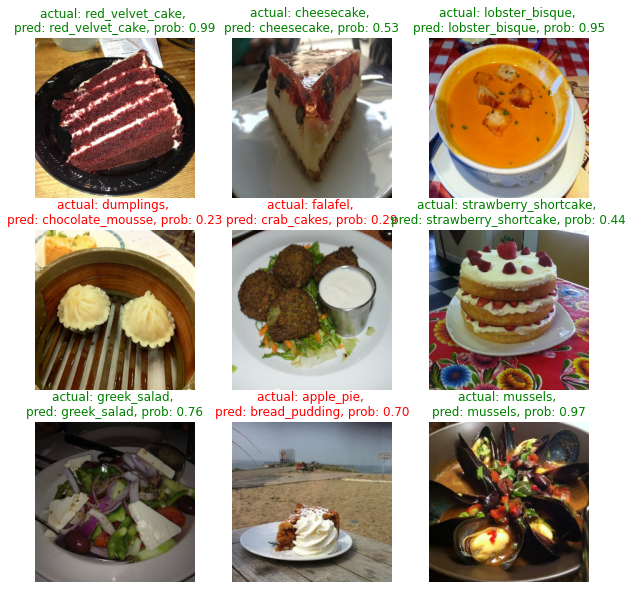

In [82]:
visualize_random_class(efficientnetb0_model, class_names=class_names, figsize=(20, 15))

## most wrong predictions

In [94]:
pred_df = pd.DataFrame({
    'y_labels':y_labels,
    'y_pred':y_preds,
    "pred_conf":pred_probs.max(axis=1),
    'true_classes':true_classes,
    'pred_classes':pred_classes
})
pred_df['pred_correct'] = pred_df["y_labels"] == pred_df['y_pred']
pred_df.head(10)

y_labels  y_pred  pred_conf     true_classes  \
0  tf.Tensor(83, shape=(), dtype=int64)      44   0.227900  red_velvet_cake   
1  tf.Tensor(57, shape=(), dtype=int64)      60   0.900715           hummus   
2  tf.Tensor(48, shape=(), dtype=int64)      29   0.944270      greek_salad   
3  tf.Tensor(79, shape=(), dtype=int64)      80   0.532355        prime_rib   
4  tf.Tensor(44, shape=(), dtype=int64)      32   0.999925       fried_rice   
5  tf.Tensor(81, shape=(), dtype=int64)      78   0.990731            ramen   
6  tf.Tensor(43, shape=(), dtype=int64)      17   0.169571   fried_calamari   
7  tf.Tensor(27, shape=(), dtype=int64)       1   0.917857     creme_brulee   
8  tf.Tensor(47, shape=(), dtype=int64)      40   0.989740          gnocchi   
9  tf.Tensor(46, shape=(), dtype=int64)      40   0.882523     garlic_bread   

           pred_classes  pred_correct  
0            fried_rice         False  
1        lobster_bisque         False  
2             cup_cakes         False  
3  pulled_pork_sandwich         False  
4             dumplings         False  
5               poutine         False  
6          cheese_plate         False  
7        baby_back_ribs         False  
8          french_fries         False  
9          french_fries         False

In [95]:
top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong.head()

y_labels  y_pred  pred_conf  \
15697  tf.Tensor(90, shape=(), dtype=int64)      33   1.000000   
10704  tf.Tensor(51, shape=(), dtype=int64)      32   1.000000   
5425   tf.Tensor(58, shape=(), dtype=int64)      33   0.999999   
5396   tf.Tensor(55, shape=(), dtype=int64)      33   0.999999   
4151   tf.Tensor(35, shape=(), dtype=int64)      33   0.999999   

              true_classes pred_classes  pred_correct  
15697  spaghetti_bolognese      edamame         False  
10704            guacamole    dumplings         False  
5425             ice_cream      edamame         False  
5396               hot_dog      edamame         False  
4151             escargots      edamame         False

In [101]:
top_100_wrong.iloc[0], top_100_wrong.index[0]

(y_labels        tf.Tensor(90, shape=(), dtype=int64)
 y_pred                                            33
 pred_conf                                        1.0
 true_classes                     spaghetti_bolognese
 pred_classes                                 edamame
 pred_correct                                   False
 Name: 15697, dtype: object, 15697)

In [110]:
for j, idx in enumerate(top_100_wrong.index):
  print(j, idx, '\t')

0 15697 	
1 10704 	
2 5425 	
3 5396 	
4 4151 	
5 37 	
6 14901 	
7 21622 	
8 3483 	
9 17688 	
10 9600 	
11 10534 	
12 21337 	
13 17543 	
14 25223 	
15 5556 	
16 17126 	
17 21073 	
18 12346 	
19 12379 	
20 8098 	
21 12259 	
22 23969 	
23 24393 	
24 6322 	
25 3058 	
26 13402 	
27 1445 	
28 17495 	
29 4368 	
30 20670 	
31 22069 	
32 16002 	
33 23312 	
34 18307 	
35 6050 	
36 14355 	
37 955 	
38 2010 	
39 8692 	
40 16025 	
41 21065 	
42 8803 	
43 13484 	
44 9265 	
45 11101 	
46 19097 	
47 18939 	
48 6614 	
49 14765 	
50 12108 	
51 22544 	
52 9017 	
53 12534 	
54 1547 	
55 14942 	
56 19606 	
57 12378 	
58 23044 	
59 9338 	
60 14636 	
61 3250 	
62 9637 	
63 8235 	
64 24748 	
65 16913 	
66 23004 	
67 5435 	
68 15968 	
69 24277 	
70 10311 	
71 9723 	
72 3398 	
73 5321 	
74 20434 	
75 21025 	
76 2259 	
77 7110 	
78 18845 	
79 3874 	
80 14800 	
81 20326 	
82 10896 	
83 8174 	
84 22575 	
85 18568 	
86 17072 	
87 15688 	
88 14575 	
89 6144 	
90 16376 	
91 19992 	
92 12548 	
93 15260 	
94 5238 	
95 

In [130]:
# save images to plot
images = []
for i, (image, _) in enumerate(test_data.unbatch()):
  for idx in top_100_wrong.index:
    if i == idx:
      images.append(image)
top_100_wrong['image'] = images
top_100_wrong.head()

y_labels  y_pred  pred_conf  \
15697  tf.Tensor(90, shape=(), dtype=int64)      33   1.000000   
10704  tf.Tensor(51, shape=(), dtype=int64)      32   1.000000   
5425   tf.Tensor(58, shape=(), dtype=int64)      33   0.999999   
5396   tf.Tensor(55, shape=(), dtype=int64)      33   0.999999   
4151   tf.Tensor(35, shape=(), dtype=int64)      33   0.999999   

              true_classes pred_classes  pred_correct  \
15697  spaghetti_bolognese      edamame         False   
10704            guacamole    dumplings         False   
5425             ice_cream      edamame         False   
5396               hot_dog      edamame         False   
4151             escargots      edamame         False   

                                                   image  
15697  (((tf.Tensor(124.62245, shape=(), dtype=float3...  
10704  (((tf.Tensor(151.0, shape=(), dtype=float32), ...  
5425   (((tf.Tensor(88.28571, shape=(), dtype=float32...  
5396   (((tf.Tensor(88.0, shape=(), dtype=float32), t...  
4151   (((tf.Tensor(183.0, shape=(), dtype=float32), ...

In [127]:
top_100_wrong.index, test_data.unbatch(), test_data

(Int64Index([15697, 10704,  5425,  5396,  4151,    37, 14901, 21622,  3483,
             17688,  9600, 10534, 21337, 17543, 25223,  5556, 17126, 21073,
             12346, 12379,  8098, 12259, 23969, 24393,  6322,  3058, 13402,
              1445, 17495,  4368, 20670, 22069, 16002, 23312, 18307,  6050,
             14355,   955,  2010,  8692, 16025, 21065,  8803, 13484,  9265,
             11101, 19097, 18939,  6614, 14765, 12108, 22544,  9017, 12534,
              1547, 14942, 19606, 12378, 23044,  9338, 14636,  3250,  9637,
              8235, 24748, 16913, 23004,  5435, 15968, 24277, 10311,  9723,
              3398,  5321, 20434, 21025,  2259,  7110, 18845,  3874, 14800,
             20326, 10896,  8174, 22575, 18568, 17072, 15688, 14575,  6144,
             16376, 19992, 12548, 15260,  5238,  9232, 15695, 19799, 15415,
              3342],
            dtype='int64'),
 <_UnbatchDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), 

In [147]:
import random

def visualize_wrong_predictions(top_100_wrong, figsize=(10, 10)):
  start_index = random.choice(range(0, 91))
  images_to_view = 9
  plt.figure(figsize=figsize)
  for i, row in enumerate(top_100_wrong[start_index: start_index + images_to_view].itertuples()):
    plt.subplot(3, 3, i + 1)
    _, _, _, pred_probs, y_label, y_pred, _, image = row
    plt.imshow(image/255.)
    title_color = 'green' if y_label == y_pred else 'red'
    plt.title(f'actual: {y_label}, pred: {y_pred}, \nprob: {pred_probs}', c=title_color)
    plt.axis(False)

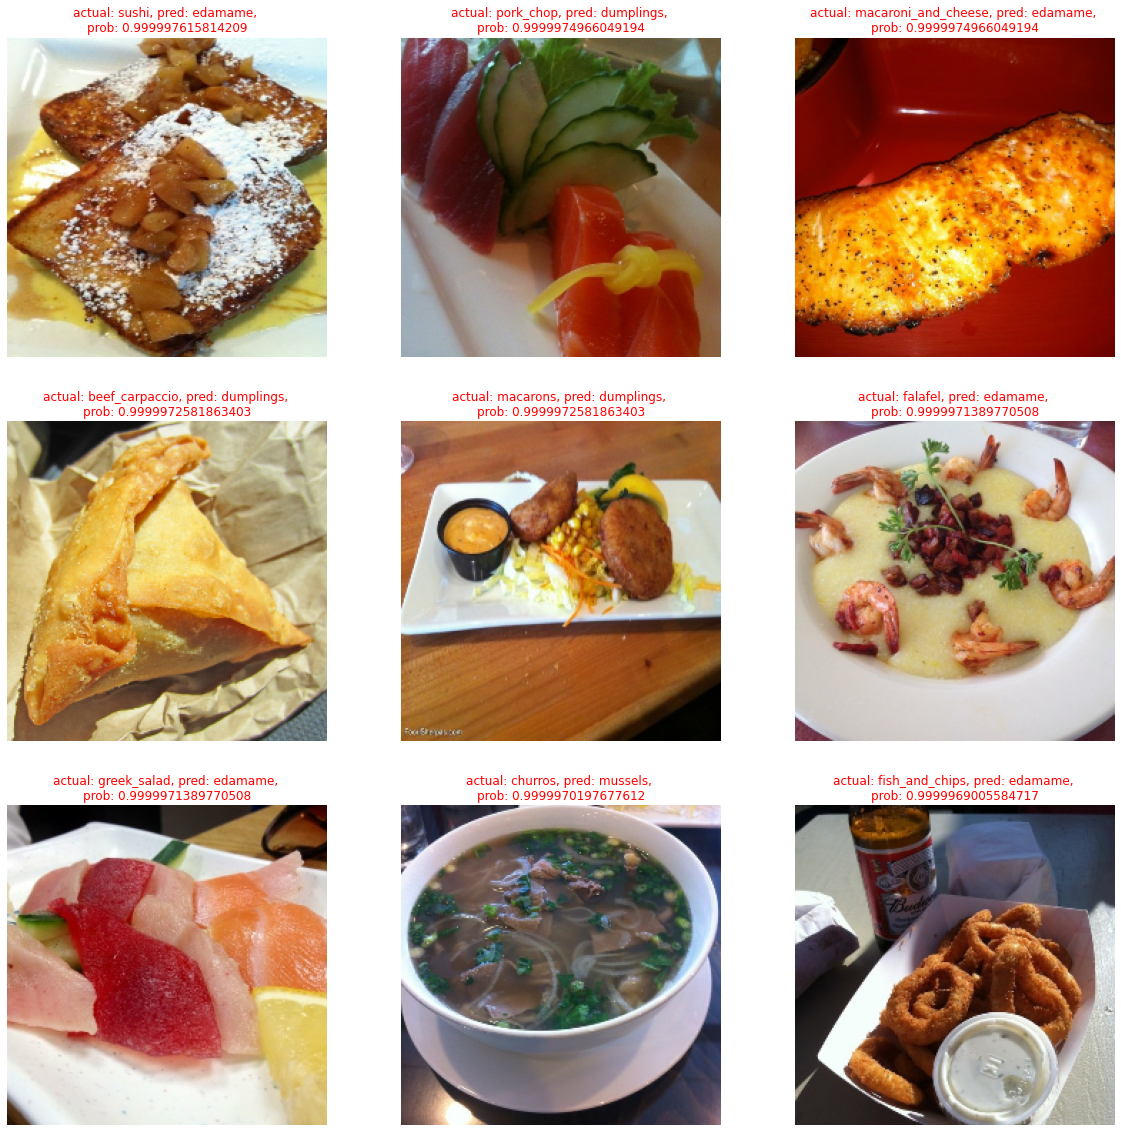

In [148]:
visualize_wrong_predictions(top_100_wrong, figsize=(20, 20))

# custom data

In [149]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

from helper_functions import unzip_data
!unzip_data('custom_food_images.zip')

--2023-03-01 19:13:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 108.177.127.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  11.2MB/s    in 1.1s    

2023-03-01 19:13:16 (11.2 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]

/bin/bash: -c: line 0: syntax error near unexpected token `'custom_food_images.zip''
/bin/bash: -c: line 0: `unzip_data('custom_food_images.zip')'


In [150]:
custom_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images/")]
custom_images

NameError: ignored

In [ ]:
from helper_functions import load_and_prep_image

def visualize_custom_images(model, custom_images, figsize=(10, 7)):
  plt.figure(figsize=figsize)
  for i in range(len(custom_images)):
    img = load_and_prep_image(custom_images[i], scale=False)

    pred_probs = model.predict(tf.expand_dims(img, axis=0))
    y_pred = tf.argmax(pred_probs, axis=1)
    class_name = class_names[int(y_pred)]

    plt.subplot(len(custom_images), 1, i + 1)  
    plt.imshow(img/255.)
    plt.title(f'pred: {class_name}, prob: {pred_probs.argmax():.2f}')
    plt.axis(False)

In [ ]:
visualize_custom_images(efficientnetb0_model, custom_images)

# EfficientNetB4

* disconnect and delete runtime and begin training on EfficientNetB4_model

In [151]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, losses, callbacks, mixed_precision

In [152]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import plot_loss_curves, create_tensorboard_callback, compare_historys

--2023-03-01 19:13:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-01 19:13:19 (83.2 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [153]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [154]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [155]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## visualize images

(512, 512, 3) <dtype: 'uint8'> () <dtype: 'int64'>


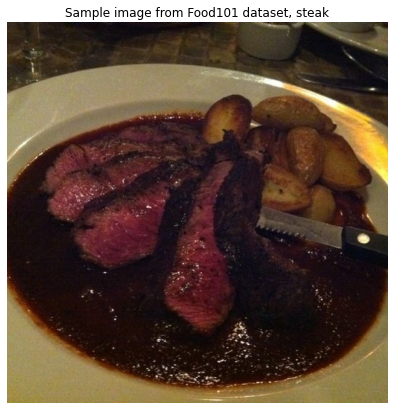

In [156]:
for image, label in test_data.take(1):
  print(image.shape, image.dtype, label.shape, label.dtype)
show_image(image, label)

## prepare data

In [157]:
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) \
  .shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) \
  .batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [158]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## model

In [159]:
# callbacks
tensorboard_callback = create_tensorboard_callback(dir_name='food_vision',
                                                   experiment_name='food_vision_big_EfficientNetB4_model_feat')

checkpoint_path = 'checkpoints/EfficientNetB4_feat_checkpoint.ckpt'
model_checkpoint = callbacks.ModelCheckpoint(checkpoint_path,
                                          monitor='val_loss',
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='min',
                                          verbose=1)

lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=.2,
                                         patience=2,
                                         min_lr=1e-7,
                                         mode='min',
                                         verbose=1)

Saving TensorBoard log files to: food_vision/food_vision_big_EfficientNetB4_model_feat/20230301-191320


In [160]:
data_augmentation = models.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(.2),
    layers.RandomZoom(.2),
    layers.RandomHeight(.2),
    layers.RandomWidth(.2),
    # layers.Rescaling(1./255)
], name='data_augmentation')

In [161]:
mixed_precision.set_global_policy(policy='mixed_float16')

In [162]:
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

input_shape = (224, 224, 3)
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
x = layers.Dense(len(train_data), name='output_layer')(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name="softmax_layer")(x)

EfficientNetB4_model = keras.Model(inputs, outputs, name='EfficientNetB4_model')

EfficientNetB4_model.compile(loss=losses.SparseCategoricalCrossentropy(),
                             optimizer=optimizers.Adam(),
                             metrics=['accuracy'])

71686520/71686520 [==============================] - 3s 0us/step


In [163]:
EfficientNetB4_model.summary()

Model: "EfficientNetB4_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling_2D (  (None, 1792)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 2368)              4245824   
                                                                 
 softmax_layer (Activation)  (None, 2368)     

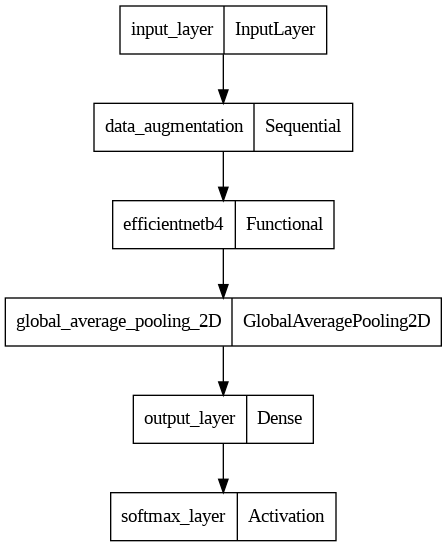

In [164]:
tf.keras.utils.plot_model(EfficientNetB4_model)

In [165]:
initial_epochs = 3
history_efficientnetb4_feat = EfficientNetB4_model.fit(
    train_data,
    epochs=initial_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=(.15 * len(test_data)),
    callbacks=[tensorboard_callback, 
               model_checkpoint, 
               lr_reducer]
)

Epoch 1/3


2368/2368 [==============================] - ETA: 0s - loss: 2.1977 - accuracy: 0.4724
Epoch 1: val_loss improved from inf to 1.40237, saving model to checkpoints/EfficientNetB4_feat_checkpoint.ckpt
2368/2368 [==============================] - 688s 280ms/step - loss: 2.1977 - accuracy: 0.4724 - val_loss: 1.4024 - val_accuracy: 0.6297 - lr: 0.0010
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7341 - accuracy: 0.5592
Epoch 2: val_loss improved from 1.40237 to 1.30673, saving model to checkpoints/EfficientNetB4_feat_checkpoint.ckpt
2368/2368 [==============================] - 634s 267ms/step - loss: 1.7341 - accuracy: 0.5592 - val_loss: 1.3067 - val_accuracy: 0.6507 - lr: 0.0010
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.6123 - accuracy: 0.5865
Epoch 3: val_loss improved from 1.30673 to 1.26744, saving model to checkpoints/EfficientNetB4_feat_checkpoint.ckpt
2368/2368 [==============================] - 627s 264ms/step - loss: 1.6123

In [166]:
results_efficientnetb4_feat = EfficientNetB4_model.evaluate(test_data)
results_efficientnetb4_feat

790/790 [==============================] - 70s 89ms/step - loss: 1.2663 - accuracy: 0.6606


[1.2662543058395386, 0.6606336832046509]

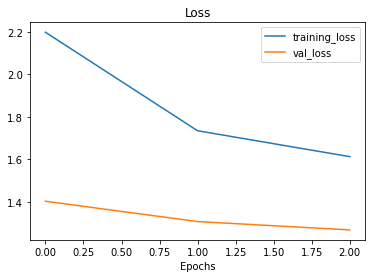

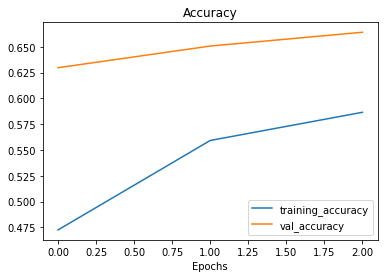

In [167]:
plot_loss_curves(history_efficientnetb4_feat)

## fine tuning

In [168]:
base_model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False
for layer in EfficientNetB4_model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
data_augmentation True float32 <Policy "mixed_float16">
efficientnetb4 True float32 <Policy "mixed_float16">
global_average_pooling_2D True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "mixed_float16">
softmax_layer True float32 <Policy "float32">


In [169]:
tensorboard_callback = create_tensorboard_callback(dir_name='food_vision',
                                                   experiment_name='food_vision_EfficientNetB4_fine_10')

early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                        patience=2,
                                        mode='min',
                                        verbose=1)

Saving TensorBoard log files to: food_vision/food_vision_EfficientNetB4_fine_10/20230301-194836


In [170]:
EfficientNetB4_model.compile(loss=losses.SparseCategoricalCrossentropy(),
                             optimizer=optimizers.Adam(0.0001),
                             metrics=['accuracy'])

In [171]:
fine_tune_epochs = initial_epochs + 100
history_efficientnetb4_fine_10 = EfficientNetB4_model.fit(
    train_data,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data),
    initial_epoch=history_efficientnetb4_feat.epoch[-1],
    validation_data=test_data,
    validation_steps=(.15 * len(test_data)),
    callbacks=[tensorboard_callback, 
               lr_reducer, 
               early_stopping]
)

Epoch 3/103


2368/2368 [==============================] - 673s 274ms/step - loss: 1.4322 - accuracy: 0.6291 - val_loss: 1.1063 - val_accuracy: 0.7082 - lr: 1.0000e-04
Epoch 4/103
2368/2368 [==============================] - 633s 266ms/step - loss: 1.3043 - accuracy: 0.6570 - val_loss: 1.0732 - val_accuracy: 0.7067 - lr: 1.0000e-04
Epoch 5/103
2368/2368 [==============================] - 640s 269ms/step - loss: 1.2131 - accuracy: 0.6791 - val_loss: 1.0440 - val_accuracy: 0.7156 - lr: 1.0000e-04
Epoch 6/103
2368/2368 [==============================] - 628s 264ms/step - loss: 1.1246 - accuracy: 0.6989 - val_loss: 1.0275 - val_accuracy: 0.7153 - lr: 1.0000e-04
Epoch 7/103
2368/2368 [==============================] - 629s 265ms/step - loss: 1.0566 - accuracy: 0.7136 - val_loss: 1.0269 - val_accuracy: 0.7124 - lr: 1.0000e-04
Epoch 8/103
2368/2368 [==============================] - 633s 266ms/step - loss: 0.9916 - accuracy: 0.7284 - val_loss: 1.0142 - val_accuracy: 0.7172 - lr: 1.0000e-04
Epoch 9/103
2368

In [172]:
results_efficientnetb4_fine_10 = EfficientNetB4_model.evaluate(test_data)
results_efficientnetb4_fine_10

790/790 [==============================] - 71s 90ms/step - loss: 1.0330 - accuracy: 0.7166


[1.032956600189209, 0.7165940403938293]

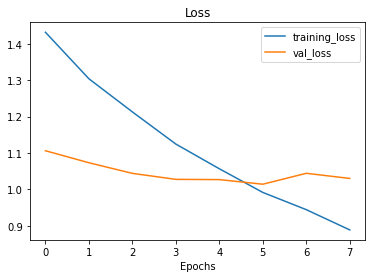

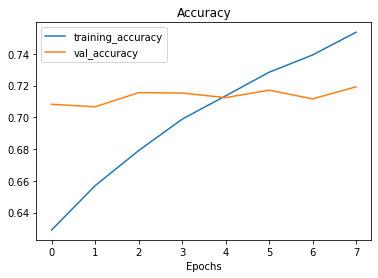

In [173]:
plot_loss_curves(history_efficientnetb4_fine_10)

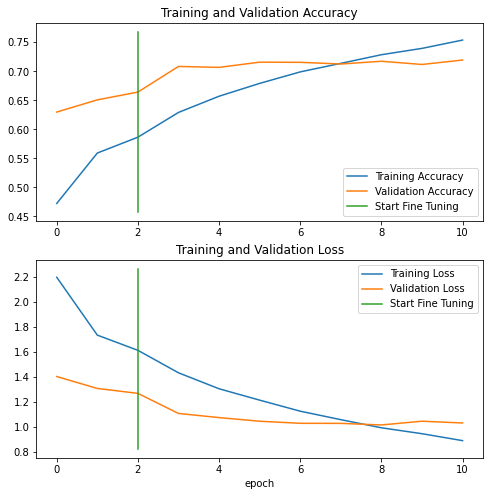

In [174]:
compare_historys(original_history=history_efficientnetb4_feat,
                 new_history=history_efficientnetb4_fine_10,
                 initial_epochs=initial_epochs)

## tensorboard visualization

In [175]:
!tensorboard dev upload --logdir ./food_vision \
  --name "food_vision_efficientnetb4_fine_10" \
  --description "food vision efficientnetb4 model on food101 dataset feature extraction for 3 epochs and fine tuning 10 layers with earlystopping" \
  --one_shot

2023-03-01 21:17:23.110366: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-01 21:17:23.110591: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-01 21:17:23.110615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/A9dsG20XSAumYnnpYBOiEw/

[2023-03-01T21:17:28] Started scanning logdir.
[2023-03-

* Done. View your TensorBoard at https://tensorboard.dev/experiment/A9dsG20XSAumYnnpYBOiEw/

In [176]:
!tensorboard dev list

2023-03-01 21:17:38.699688: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-01 21:17:38.699824: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-01 21:17:38.699845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
https://tensorboard.dev/experiment/A9dsG20XSAumYnnpYBOiEw/
	Name                 food_vision_efficientnetb4_fine_10
	Description          food vision efficientnetb4 mo

In [177]:
# !tensorboard dev delete --experiment_id 

In [178]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [179]:
# EfficientNetB4_model.save('models/EfficientNetB4_model_feat_3_fine_10.h5')
# EfficientNetB4_model.save('/content/drive/MyDrive/food_vision/models/EfficientNetB4_feat_3_fine_10.h5')

In [180]:
# json serialization error in tf 2.11
# model = models.load_model('models/EfficientNetB4_model_feat_3_fine_10.h5')
# model = models.load_model('/content/drive/MyDrive/food_vision/models/EfficientNetB4_feat_3_fine_10.h5')

## Evaluation

In [ ]:
pred_probs = EfficientNetB4_model.predict(test_data)
y_preds = tf.argmax(pred_probs, axis=1)
y_labels = []
img_index = 0
for image, label in test_data.unbatch():
  y_labels.append(label)
pred_classes = [class_names[i] for i in y_preds]
true_classes = [class_names[i] for i in y_labels]

In [ ]:
from sklearn.metrics import classification_report
classification_report_dict = classification_report(y_labels, y_preds, output_dict=True)
classification_report_dict

In [ ]:
class_names = ds_info.features['label'].names
class_names

In [ ]:
class_f1_score = {}
for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break
  class_f1_score[class_names[int(k)]] = v['f1-score']
class_f1_score

In [ ]:
f1_score_dict = pd.DataFrame({
    'class_name':list(class_f1_score.keys()),
    'f1_score':list(class_f1_score.values())
}).sort_values('f1_score', ascending=False)
f1_score_dict.head()

In [ ]:
plot_f1_score(f1_score_dict)

In [ ]:
make_confusion_matrix(y_labels, y_preds, classes=class_names, figsize=(100, 100), text_size=20)

In [ ]:
visualize_random_class(EfficientNetB4_model)

In [ ]:
pred_df = pd.DataFrame({   
    'y_labels':y_labels,
    'y_preds':y_preds,
    'pred_conf':pred_probs.max(axis=1),
    'true_classes':true_classes,
    'pred_classes':pred_classes,
})
pred_df['pred_correct'] = pred_df['y_preds'] == pred_df['y_labels']
pred_df.head()

In [ ]:
top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong.head()

In [ ]:
images = []
for i, (image, _) in enumerate(test_data.unbatch()):
  for idx in top_100_wrong.index:
    if i == idx:
      images.append(image.numpy())
top_100_wrong['image'] = images
top_100_wrong.head()

In [ ]:
visualize_wrong_predictions(top_100_wrong, figsize=20, 20)

## custom_images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
!unzip "custom_food_images.zip"

In [ ]:
import os
custom_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images/")]
custom_images

In [ ]:
visualize_custom_images(EfficientNetB4_model, custom_images, figsize=(20, 20))

In [ ]:
# EfficientNetB4_model.save_weights('models/food_vision_EfficientNetB4_fine_10.h5')

In [ ]:
# EfficientNetB4_model.load_weights('models/food_vision_EfficientNetB4_fine_10.h5')